In [3]:
#!/usr/bin/env python
# coding: utf-8
# %load qbo2netcdf.py
'''
Read QBO data from the following files : singapore.dat, qbo.dat
'''

import numpy as np
import pandas as pd
import matplotlib.dates as mpl_dates
import datetime
import xarray as xr
import cftime
from dateutil.relativedelta import relativedelta


def replace_nan(up):
    # Assuming 'up' is your two-dimensional array
    # Replace NaN values with the mean of surrounding non-NaN values, excluding boundaries
    up_copy = up.copy()  # Create a copy to avoid modifying the original array
    nan_mask = np.isnan(up)

    # Loop through rows and columns
    for i in range(1, up.shape[0] - 1):
        for j in range(1, up.shape[1] - 1):
            if nan_mask[i, j]:
                # Replace NaN value with the mean of surrounding non-NaN values
                up_copy[i, j] = np.nanmean(up[i-1:i+2, j-1:j+2])

    # Replace the original array with the modified copy
    up = up_copy
    return up

def read_100hPa():
    file_path = '../data/100hPa_1957-1996.txt'
    df = pd.read_csv(file_path, sep=r'\s+', skiprows=16, header=None, names=['station_number', 'year', 'month', 'u'])
    # Combine 'year' and 'month' into a single 'date' column
    df['date'] = pd.to_datetime(df[['year', 'month']].assign(DAY=1))

    # Drop the 'year' and 'month' columns if not needed separately
    df = df.drop(['year', 'month'], axis=1)
    #df.u=df.u*0.1
    
    return df

def read_singapore(nmonth, nyear, file_path='../QBO/qbo_data/singapore.dat'):
    headerlines = []
    ye = []
    dats = []
    date = []
    pressure = [100, 90, 80, 70, 60, 50, 45, 40, 35, 30, 25, 20, 15, 12, 10]
    altitude = -7 * np.log(np.array(pressure) / 1013.15)

    with open(file_path) as file:
        for i in range(3):
            headerlines.append(file.readline().strip())
            print(headerlines)
            
        for year in range(1987, nyear + 1):
            if year == nyear:
                data = np.zeros([nmonth, 15]) * np.nan
            else:
                data = np.zeros([12, 15]) * np.nan

            ye.append(file.readline().strip())
            file.readline()

            if year < 1997:
                for i in range(14):
                    cols = file.readline().strip().split()
                    for j in range(1, 13):
                        if i == 1:
                            date.append(datetime.datetime(year, j, 1))
                        data[j - 1, i] = float(cols[j])
            else:
                for i in range(15):
                    cols = file.readline().strip().split()
                    for j in range(1, 13):
                        if j < nmonth + 1 or year < nyear:
                            if i == 1:
                                date.append(datetime.datetime(year, j, 1))
                            data[j - 1, i] = float(cols[j])

            dats.extend(data.tolist())
            file.readline()

    fds = list(mpl_dates.date2num(date))
    fds = np.array(fds)
    
    return np.array(dats).T[::-1], fds, pressure, altitude, date


def read_qbo(file_path='../QBO/qbo_data/qbo.dat'):
    # Open the file to read the header
    with open(file_path, 'r') as file:
        # Read the first 9 lines and print them
        header_lines = [file.readline().strip() for _ in range(9)]
        print("\n".join(header_lines))
    
    data = np.genfromtxt(file_path, skip_header=9,
                         dtype=['S6', 'S4', 'i4', 'i1', 'i4', 'i1', 'i4', 'i1', 'i4', 'i1', 'i4', 'i1', 'i4', 'i1', 'i4', 'i1'],
                         names=['station', 'date', 'p70', 'n70', 'p50', 'n50', 'p40', 'n40', 'p30', 'n30', 'p20', 'n20', 'p15', 'n15', 'p10', 'n10'],
                         delimiter=[6, 4, 6, 2, 5, 2, 5, 2, 5, 2, 5, 2, 5, 2, 5, 2],
                         filling_values=-999999, missing_values=' ')

    station = np.char.strip(np.char.decode(data['station'], 'utf-8')).astype(str)

    # Convert date strings to datetime objects
    date = []
    station = []
    for i in range(len(data)):
        station.append(data['station'][i])
        if int(data['date'][i]) > 5000:
            date.append(datetime.datetime.strptime('19'+(data['date'][i]).decode('UTF-8'),'%Y%m'))
        else:
            date.append(datetime.datetime.strptime('20'+(data['date'][i]).decode('UTF-8'),'%Y%m'))

    fds = mpl_dates.date2num(date)

    #date = [datetime.datetime.strptime(('19' if int(year) > 5000 else '20') + year.decode('UTF-8') + month.decode('UTF-8'), '%Y%m') for year, month in zip(data['date'], data['date'])]
    #fds = mpl_dates.date2num(date)
    up = np.array([data['p70'], data['p50'], data['p40'], data['p30'], data['p20'], data['p15'], data['p10']])
    un = np.array([data['n70'], data['n50'], data['n40'], data['n30'], data['n20'], data['n15'], data['n10']])
    
    pressure = [70, 50, 40, 30, 20, 15, 10]
    altitude = -7 * np.log(np.array(pressure) / 1013.15)
    
    return up, fds, pressure, altitude, station, un, date


def convert2netcdf(date, dateaddmonth, u, pressure, fname, station):
    # Define station information
    station_info = {
        '91700': {'name': 'KIRIBATI Canton Island', 'latitude': -(2 + 46 / 60), 'longitude': -(171 + 43 / 60), 'altitude': 13},
        '48968': {'name': 'SINGAPORE Changi', 'latitude': 1 + 22 / 60 + 4 / (60 * 60), 'longitude': 103 + 58 / 60 + 57 / (60 *60), 'altitude': 14},
        '48698': {'name': 'SINGAPORE Changi', 'latitude': 1 + 22 / 60 + 4 / (60 * 60), 'longitude': 103 + 58 / 60 + 57 / (60 *60), 'altitude': 14},
        '48964': {'name': 'SINGAPORE Payalebar', 'latitude': 1 + 22 / 60, 'longitude': 103 + 55 / 60, 'altitude': 18},
        '48694': {'name': 'SINGAPORE Payalebar', 'latitude': 1 + 22 / 60, 'longitude': 103 + 55 / 60, 'altitude': 18},
        '08694': {'name': 'SINGAPORE Payalebar', 'latitude': 1 + 22 / 60, 'longitude': 103 + 55 / 60, 'altitude': 18},
        '43599': {'name': 'MALEDIVES Gan Island', 'latitude': -41 / 60 - 36 / (60 * 60), 'longitude': 73 + 9 / 60 + 20 / (60 * 60), 'altitude': 1.8},
    }

    # For levels above 100 hPa data until 1967  8 
    # KIR	KI	Kiribati	-	Kanton	Canton Island|Kanton Village	Canton Island AP|Topham Field		KIaaPCIS	x			
    #     91700	60701	KRC00914101		-2.76666666666667	-171.716666666667	13.0	Pacific/Enderbury		
    #     KIR,KI,Kiribati,-,Kanton,Canton Island|Kanton Village,Topham Field,,KIaaPCIS,PCIS,CHR,
    #     91700,60701,,m,PCIS,A,ICA12 ICA10 ICA09 PAA82,CIS,,CAA48,91700,,,917000,,60701,,,
    #     -2.767,-171.717,C,,3,,,3,,,Pacific/Enderbury,-,,,,,
    #                             ADJ/20120717 ADJ/20120717 FAA LID no longer in use.,-2,-171
    
    # For 100 hPa data until 1967  9 
    # KIR	KI	Kiribati	-	Kanton	Canton Island|Kanton Village	Canton Island AP|Topham Field		KIaaPCIS	-	PCIS		
    #      91701	60703	KRW00060703		-2.76666666666667	-171.716666666667	2.0	Pacific/Enderbury

    # For 100 hPa data from 1967  10 until 1996 12 and above 100 hPa from 1989 6
    # SGP	SG	Singapore	-	-	Singapore|Kampong Darat Nanas	Changi		SGaaWSSS	-	WSSS		
    #     48698		SNM00048698		1.36777777777778	103.9825	14.0	Asia/Singapore
    #     SGP,SG,Singapore,-,-,Singapore|Kampong Darat Nanas,Changi,,SGaaWSSS,WSSS,,
    #     48698,,SIN,m,WSSS,A,ICA12 ICA10 ICA09,,,,48698,A,WMO13 WMO12 WMO11,486980,,,,,
    #     1.366666667,103.9833333,G,WMO13 WMO12 WMO11 WMO10,5,C,WMO13 WMO12 WMO11 WMO10,
    #                             16,C,WMO13 WMO12 WMO11 WMO10,Asia/Singapore,MY-
    
    # Above 100 hPa data from 1976  1 until 1989 5
    # SGP	SG	Singapore	-	-	Singapore|Teck Hock	Payalebar		SGaaWSAP	-	WSAP		
    #     48694				1.36666666666667	103.916666666667	18.0	Asia/Singapore
    #     SGP,SG,Singapore,-,-,Singapore|Teck Hock,Payalebar,,SGaaWSAP,WSAP,,
    #     48694,,QPG,m,WSAP,A,ICA12 ICA10 ICA09,,,,48694,A,WMO13 WMO12 WMO11,486940,,,,,
    #     1.366666667,103.9166667,G,WMO13 WMO12 WMO11 WMO10,18,C,WMO13 WMO12 WMO11 WMO10,
    #                             32,C,WMO13 WMO12 WMO11 WMO10,Asia/Singapore,MY-81600,,,,,ADJ/20120717,1,103
    
    # Above 100 hPa data from 1967  9 until 1975  12 
    # MDV	MV	Maldives	ADD	-	Gan Island	Gan Island		MVaaVRGN	-	VRGN		
    #     43599				-0.693333333333333	73.1555555555556	1.8	Indian/Maldives
    #     MDV,MV,Maldives,ADD,-,Gan Island,,,MVaaVRGN,VRGN,,43599,,,m,VRGN,A,ICA95,,,,
    #     43599,A,WMO13 WMO12 WMO11,435990,,,,,
    #     -0.693333333,73.15555556,G,WMO13 WMO12 WMO11 WMO10,1.8,C,WMO13 WMO12 WMO11,
    #                              2.8,C,WMO13 WMO12 WMO11 WMO10,Indian/Maldives,-,,,,,
    #                              "Listed as VRGN in an unreliable third-party source, 
    #                              but unable to find such an identifier in any 
    #                              authoritative references.",0,73

    
    # Extract station information based on station codes
    station_number = [s_code for s_code in station]
    station_name   = [station_info[s_code]['name'] for s_code in station_number]
    latitude       = [station_info[s_code]['latitude'] for s_code in station_number]
    longitude      = [station_info[s_code]['longitude'] for s_code in station_number]
    altitude       = [station_info[s_code]['altitude'] for s_code in station_number]

    # Replace NaN values in 'u' with a specific fill value (e.g., -9999)
    u = np.where(np.isnan(u), -9999.0, u)
    print(u)
    # Create xarray dataset
    ds = xr.Dataset({
        'u': (['time', 'pressure'], u),
        'station_number': (['time'], np.array(station_number, dtype='int32')),     # Convert station_number and station_name to numpy arrays
        'station_name': (['time'], np.array(station_name, dtype='S13')),  # Assuming a maximum string length of 13, adjust as needed
        'station_latitude': (['time'], latitude),
        'station_longitude': (['time'], longitude),
        'station_altitude': (['time'], altitude),
        'time_bnds': (['time', 'nv'], np.array([date, dateaddmonth], dtype='int32').T),
    },
    coords={
        'pressure': np.array(pressure, dtype='int32'),
        'time': np.array(date, dtype='int32'),
        'nv': np.array([0, 1], dtype='int32'), 
    })
    
    # Create a new variable for the quality flag
    ds['u_qc'] = xr.where((ds['u'] >= -200) & (ds['u'] <= 200), 0, 1).astype(np.int32)

    # Add attributes to variables
    ds['station_name'].attrs = {'long_name': 'Station Name',
                                'standard_name': 'platform_name'}
    ds['station_number'].attrs = {'long_name': 'Station WMO ID', 
                                  'standard_name': 'platform_id',
                                  'units': '1'} 
    ds['u_qc'].attrs = {'long_name': 'Quality flag for eastward wind',
                        'flag_values': np.array([0, 1], dtype=np.int32),
                        'flag_meanings': 'interpolated missing'}
    ds['time_bnds'].attrs = {'long_name': 'Time Bounds', 
                             'units': 'days since 1950-01-01 00:00:00'}
    ds['nv'].attrs = {'long_name': 'Number of Vertices in Bounds',
                      'units': 'count'}
    ds['time'].attrs = {'standard_name': 'time', 
                        'long_name': 'Time', 
                        'units': 'days since 1950-01-01 00:00:00', 
                        'calendar': 'standard',  # You can adjust the calendar type based on your data
                        #'cell_methods': 'time: mean (interval: 1 month)',
                        'bounds': 'time_bnds'}
    #ds['time'].attrs['interval'] = '1 month'
    ds['u'].attrs = {'standard_name': 'eastward_wind', 
                     'long_name': 'Eastward Wind', 
                     'units': 'm/s', 
                     'cell_methods': 'time: mean (interval: 1 month)',
                     #'_FillValue': -9999., #np.nan,
                     'missing_value': -9999., #np.nan,
                     'u_qc': 0}
    #ds['u'].attrs['interval'] = '1 month'
    ds['pressure'].attrs = {'standard_name': 'air_pressure', 
                            'long_name': 'Atmospheric Pressure', 
                            'units': 'hPa', 
                            'axis': 'Z'}
    ds['station_latitude'].attrs = {'long_name': 'Station Latitude',
                            'standard_name': 'latitude',
                            'units': 'degrees_north'}
    ds['station_longitude'].attrs = {'long_name': 'Station Longitude',
                            'standard_name': 'longitude',
                            'units': 'degrees_east'}
    ds['station_altitude'].attrs = {'long_name': 'Station Altitude',
                            'standard_name': 'altitude',
                            'units': 'm',
                            'positive': 'up'}  # Adjust the direction if needed (e.g., 'down')

    # Add global attributes
    ds.attrs = {
        'Conventions': 'CF-1.8, CF-1.6, CF-1.7, IOOS-1.2, ACDD-1.3',
        'title': 'Monthly mean zonal winds',
        'summary': 'Collection of tropical winds originally from the FU Berlin to represent QBO data',
        'history': 'Created by Tobias Kerzenmacher using FUB processing chain',
        'source': 'FUB and Singapore radiosondes',
        'comment': 'Monthly mean zonal winds at the levels 100, 90, 80, 70, 60, 50, 45, 40, 35, 30, 25, 20, 15, 12, and 10-hPa from Radiosonde data of the four radiosonde stations KIRIBATI Canton Island (closed 1967), MALEDIVES Gan Island (closed 1975), SINGAPORE Payalebar (until 1989), and SINGAPORE Changi (from 1989) near the equator from 1953 to the present. Values for 100 hPa from from October 1967 until December 1996 are entirely from Singapore, values at 100 hPa before October 1967 where available are from Kiribati (Canton Island). ',
        'institution': 'Karlsruhe Institute of Technology (KIT), Institute of Meteorology and Climate Research (IMK), Germany',
        'institution_id': 'ROR:04t3en479',
        'license': 'CC-BY 4.0',
        'keywords': 'QBO, radiosonde, zonal wind',
        'frequency': '1M',
        'creator_url': 'https://orcid.org/0000-0001-8413-0539',
        'creator_email': 'kerzenmacher@kit.edu',
        'contact': 'kerzenmacher@kit.edu',
        'creation_date': datetime.datetime.now().strftime('%Y-%m-%d_%H-%M-%S'),
        'further_info_url': 'https://www.atmohub.kit.edu/english/807.php',
        'references': 'Barbara Naujokat (1986) doi: https://doi.org/10.1175/1520-0469(1986)043<1873:AUOTOQ>2.0.CO;2 Christian Marquardt (1998) Die tropische QBO und dynamische Prozesse in der Stratosphäre. PhD Thesis, Met. Abh. FU-Berlin, Serie A, Band 9/Heft 4, Verlag Dietrich Reimer Berlin, 260 S.',
        'standard_name_vocabulary': 'CF Standard Name Table, Version 83',
        'crs': 'wgs84'
    }

    # Write to NetCDF file
    ds.to_netcdf(fname)

    return ds


# Read data from QBO
up1, fds1, pressure1, altitude1, station, un, da1 = read_qbo()

# Read data from Singapore
# In order to read the Singapore data, the end year and the fractional month are necessary
nmonth = np.shape(up1)[1] % 12  # number of months above a whole year
nyear = mpl_dates.num2date(fds1[-1]).year
if nmonth == 0: nyear = nyear + 1
up2, fds2, pressure, altitude, da2 = read_singapore(nmonth, nyear)

# Read missing data at 100 hPa
up100 = read_100hPa()

# Create an empty array of eastward winds over 15 altitudes and the total number of months
tnmoth = np.shape(up1)[1]  # total number of months
up = np.zeros([15, tnmoth]) * np.nan

# Stack time data from QBO and Singapore
fds = fds1
fds[-fds2.size:] = fds2
fds = np.array(fds)

# Assemble eastward wind data into a single array for the QBO data only certain altitudes are present 
up1 = up1 * 1.  # Copy the array to avoid modifying the original data
up1[up1 < -10000] = np.nan
up[[3, 5, 7, 9, 11, 12, 14], :] = up1
#up[3,:]  = up1[0,:]
#up[5,:]  = up1[1,:]
#up[7,:]  = up1[2,:]
#up[9,:]  = up1[3,:]
#up[11,:] = up1[4,]
#up[12,:] = up1[5,:]
#up[14,:] = up1[6,:]

# Stack the Singapore data which are available at all altitudes at the end of the QBO data
#up[-up2.shape[0]:, -up2.shape[1]:] = up2
up = np.hstack((up[:, :-up2.shape[1]], up2))

# Add the windspeeds at 100hPa for the years 1957-1996
fds100 = list(mpl_dates.date2num(up100.date.values))
fds100 = np.array(fds100)
# Find the index where the first date in fds100 corresponds to a value in fds
start_index = np.where(fds == fds100[0])[0][0]
# Include the windspeeds at 100hPa into the 'up' array
#up[start_index:start_index + up100.u.values.shape[0], 0] = up100.u.values
up[0,start_index:start_index + up100.u.values.shape[0]] = up100.u.values

#up = replace_nan(up)

# Convert date strings to datetime objects
time = mpl_dates.num2date(fds)

# Add one month to the date range so that time bounds can be defined
offset = relativedelta(months=1)
timeaddmonth = [pd.to_datetime(t) + offset for t in time]

# Convert dates to CFTime-compatible format
date = cftime.date2num(time, 'days since 1950-01-01 00:00:00', 'standard')
dateaddmonth = cftime.date2num(timeaddmonth, 'days since 1950-01-01 00:00:00', 'standard')

# Create netCDF file
fname = 'radiosonde_tropical_eastward_wind_{:04d}{:02d}.nc'.format(time[0].year, time[0].month)
ds = convert2netcdf(date, dateaddmonth, up.T * 0.1, pressure, fname, [x.decode("utf-8").strip() for x in station])


Monthly mean zonal wind components u (0.1 m/s)

IIIII=91700      CANTON ISLAND  02 46 S  171 43 W
=43599      GAN/MALEDIVES  00 41 S   73 09 E
=48694/698  SINGAPORE      01 22 N  103 55 E
YY=year  MM=month
N=1-9 if less than 10 daily values, =0 inter/extrapolated values

IIIII YYMM  70hPaN 50hPaN 40hPaN 30hPaN 20hPaN 15hPaN 10hPaN
['Monthly mean zonal wind components ( 0.1 m/s)']
['Monthly mean zonal wind components ( 0.1 m/s)', 'at Singapore (48698), 1N/104E']
['Monthly mean zonal wind components ( 0.1 m/s)', 'at Singapore (48698), 1N/104E', '']
[[-9.999e+03 -9.999e+03 -9.999e+03 ...  1.000e+00 -9.999e+03 -9.999e+03]
 [-9.999e+03 -9.999e+03 -9.999e+03 ... -6.000e+00 -9.999e+03 -9.999e+03]
 [-9.999e+03 -9.999e+03 -9.999e+03 ... -1.000e+01 -9.999e+03 -9.999e+03]
 ...
 [-2.300e+00  3.000e+00  3.900e+00 ... -2.800e+01  0.000e+00  7.200e+00]
 [-2.900e+00 -4.900e+00 -5.500e+00 ... -1.290e+01  4.300e+00  8.700e+00]
 [-4.600e+00 -4.100e+00 -1.600e+00 ...  5.300e+00  1.120e+01  1.270e+01]]


In [3]:
np.unique(date, return_counts="TRUE")
np.where(np.diff(date)<0)
#date[417:422]

(array([], dtype=int64),)

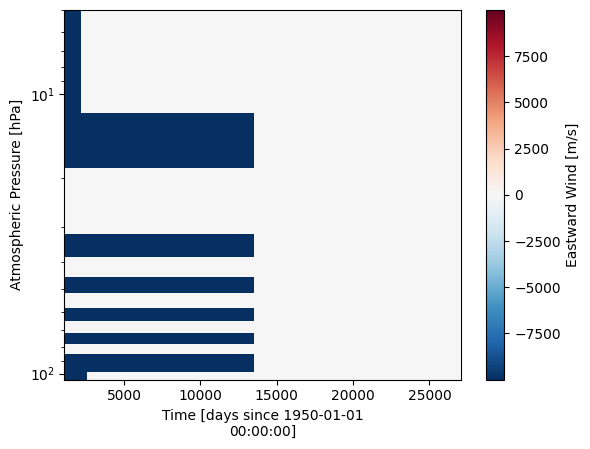

In [4]:
replace_nan(ds.u).plot.imshow(y='pressure',yscale='log', yincrease=False, )

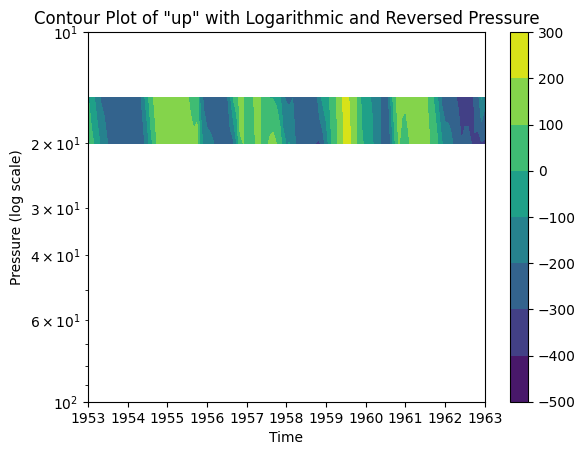

In [4]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Assuming you have 'time', 'pressure', and 'up' arrays defined
plt.yscale('log')  # Set the y-axis scale to logarithmic
plt.gca().invert_yaxis()  # Invert the y-axis

# Assuming 'time' is in datetime format
plt.contourf(time, pressure, up)
# Convert datetime strings to datetime objects
start_date = pd.to_datetime('1953-01-01')
end_date = pd.to_datetime('1963-01-01')

# Set x-axis limits
plt.xlim(start_date, end_date)


# Format x-axis ticks to show years
plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

plt.xlabel('Time')
plt.ylabel('Pressure (log scale)')
plt.title('Contour Plot of "up" with Logarithmic and Reversed Pressure')
plt.colorbar()
plt.show()


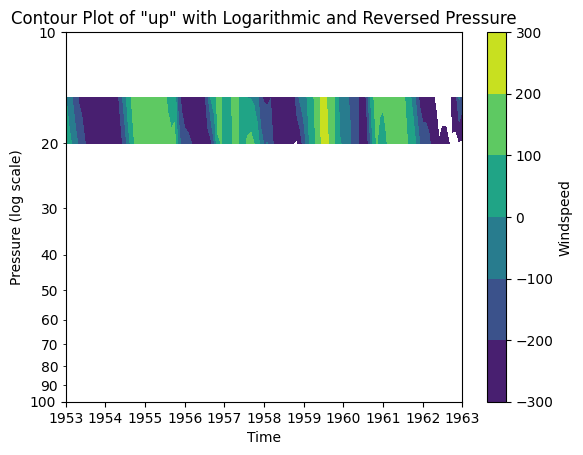

In [5]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.ticker import ScalarFormatter

# Assuming you have 'time', 'pressure', and 'up' arrays defined
plt.yscale('log')  # Set the y-axis scale to logarithmic
plt.gca().invert_yaxis()  # Invert the y-axis
ticks=[-300, -200, -100, 0, 100, 200, 300]
# Assuming 'time' is in datetime format
plt.contourf(time, pressure, up, levels=ticks)  # Adjust the number of levels as needed

# Convert datetime strings to datetime objects
start_date = pd.to_datetime('1953-01-01')
end_date = pd.to_datetime('1963-01-01')

# Set x-axis limits
plt.xlim(start_date, end_date)

# Format x-axis ticks to show years
plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

# Format y-axis ticks as integers
plt.gca().yaxis.set_major_formatter(ScalarFormatter())
plt.gca().yaxis.set_minor_formatter(ScalarFormatter())

# Set colorbar limits and label
cbar = plt.colorbar(label='Windspeed')#, ticks=[-300, -200, -100, 0, 100, 200, 300])

plt.xlabel('Time')
plt.ylabel('Pressure (log scale)')
plt.title('Contour Plot of "up" with Logarithmic and Reversed Pressure')
plt.show()



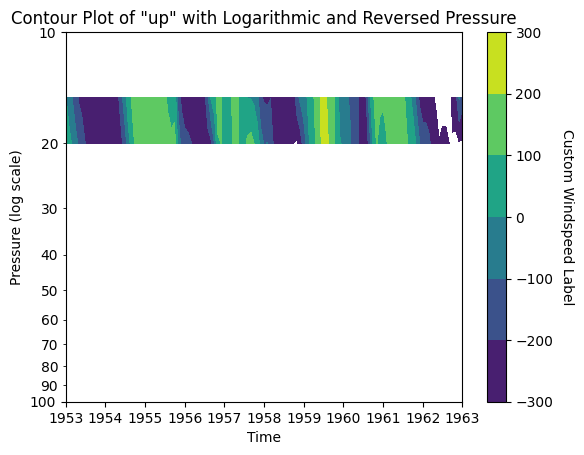

In [6]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.ticker import ScalarFormatter

# Assuming you have 'time', 'pressure', and 'up' arrays defined
plt.yscale('log')  # Set the y-axis scale to logarithmic
plt.gca().invert_yaxis()  # Invert the y-axis

# Assuming 'time' is in datetime format
plt.contourf(time, pressure, up, levels=ticks, cmap='viridis')  # Adjust the colormap and number of levels as needed

# Convert datetime strings to datetime objects
start_date = pd.to_datetime('1953-01-01')
end_date = pd.to_datetime('1963-01-01')

# Set x-axis limits
plt.xlim(start_date, end_date)

# Format x-axis ticks to show years
plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

# Format y-axis ticks as integers
plt.gca().yaxis.set_major_formatter(ScalarFormatter())
plt.gca().yaxis.set_minor_formatter(ScalarFormatter())

# Set colorbar limits and label
cbar = plt.colorbar(label='Windspeed', ticks=[-300, -200, -100, 0, 100, 200, 300])

# Customize colorbar appearance
cbar.ax.tick_params(labelsize=10)  # Adjust the font size of colorbar labels
cbar.set_label('Custom Windspeed Label', rotation=270, labelpad=15)  # Rotate and add padding to colorbar label

plt.xlabel('Time')
plt.ylabel('Pressure (log scale)')
plt.title('Contour Plot of "up" with Logarithmic and Reversed Pressure')
plt.show()


/var/folders/00/hbv3fx115yx7drr245f5hxmm0000gn/T/ipykernel_34914/1174319543.py:18: RuntimeWarning: Mean of empty slice
  up_copy[i, j] = np.nanmean(up[i-1:i+2, j-1:j+2])


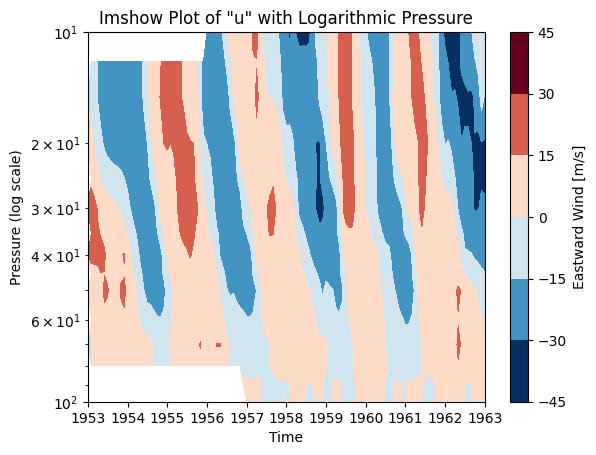

In [15]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np


def replace_nan(up):
    # Assuming 'up' is your two-dimensional array
    # Replace NaN values with the mean of surrounding non-NaN values, excluding boundaries
    up_copy = up.copy()  # Create a copy to avoid modifying the original array
    nan_mask = np.isnan(up)

    # Loop through rows and columns
    for i in range(1, up.shape[0] - 1):
        for j in range(1, up.shape[1] - 1):
            if nan_mask[i, j]:
                # Replace NaN value with the mean of surrounding non-NaN values
                up_copy[i, j] = np.nanmean(up[i-1:i+2, j-1:j+2])

    # Replace the original array with the modified copy
    up = up_copy
    return up


ds = xr.open_dataset('radiosonde_tropical_eastward_wind_195301.nc')
# Assuming you have 'ds' as your dataset and 'pressure' and 'u' as variables
#ax = replace_nan(ds.u).plot.imshow(y='pressure', yscale='log', yincrease=False)
ax = replace_nan(ds.u).plot.contourf(y='pressure', yscale='log', yincrease=False)

# Convert datetime strings to datetime objects
start_date = pd.to_datetime('1953-01-01')
end_date = pd.to_datetime('1963-01-01')

# Convert datetime objects to numeric values
start_date_num = mdates.date2num(start_date)
end_date_num = mdates.date2num(end_date)

# Access the underlying Axes object
# Access the underlying Axes object
axes = ax.get_figure().get_axes()[0]
#axes = ax.get_axes()

# Set x-axis limits
axes.set_xlim(start_date_num, end_date_num)

plt.xlabel('Time')
plt.ylabel('Pressure (log scale)')
plt.title('Imshow Plot of "u" with Logarithmic Pressure')
#plt.colorbar(label='Windspeed')
plt.show()

In [6]:
ds

<xarray.Dataset> Size: 199kB
Dimensions:            (time: 854, pressure: 15, nv: 2)
Coordinates:
  * pressure           (pressure) int32 60B 100 90 80 70 60 ... 25 20 15 12 10
  * time               (time) int32 3kB 1096 1127 1155 ... 26997 27028 27059
  * nv                 (nv) int32 8B 0 1
Data variables:
    u                  (time, pressure) float64 102kB -9.999e+03 ... 8.7
    station_number     (time) int32 3kB 91700 91700 91700 ... 48698 48698 48698
    station_name       (time) |S13 11kB b'KIRIBATI Cant' ... b'SINGAPORE Cha'
    station_latitude   (time) float64 7kB -2.767 -2.767 -2.767 ... 1.368 1.368
    station_longitude  (time) float64 7kB -171.7 -171.7 -171.7 ... 104.0 104.0
    station_altitude   (time) float64 7kB 13.0 13.0 13.0 13.0 ... 14.0 14.0 14.0
    time_bnds          (time, nv) int32 7kB 1096 1127 1127 ... 27059 27059 27088
    u_qc               (time, pressure) int32 51kB 1 1 1 0 1 0 1 ... 0 0 0 0 0 0
Attributes: (12/19)
    Conventions:               CF-1.8, CF-1.6, CF-1.7, IOOS-1.2, ACDD-1.3
    title:                     Monthly mean zonal winds
    summary:                   Collection of tropical winds originally from t...
    history:                   Created by Tobias Kerzenmacher using FUB proce...
    source:                    FUB and Singapore radiosondes
    comment:                   Monthly mean zonal winds at the levels 100, 90...
    ...                        ...
    contact:                   kerzenmacher@kit.edu
    creation_date:             2024-03-05_07-26-35
    further_info_url:          https://www.atmohub.kit.edu/english/807.php
    references:                Barbara Naujokat (1986) doi: https://doi.org/1...
    standard_name_vocabulary:  CF Standard Name Table, Version 83
    crs:                       wgs84

In [7]:
ds.u

<xarray.DataArray 'u' (time: 854, pressure: 15)> Size: 102kB
array([[-9.999e+03, -9.999e+03, -9.999e+03, ...,  1.000e+00, -9.999e+03,
        -9.999e+03],
       [-9.999e+03, -9.999e+03, -9.999e+03, ..., -6.000e+00, -9.999e+03,
        -9.999e+03],
       [-9.999e+03, -9.999e+03, -9.999e+03, ..., -1.000e+01, -9.999e+03,
        -9.999e+03],
       ...,
       [-1.000e-01,  1.100e+00,  4.600e+00, ..., -3.420e+01, -1.360e+01,
         4.500e+00],
       [-2.300e+00,  3.000e+00,  3.900e+00, ..., -2.800e+01,  0.000e+00,
         7.200e+00],
       [-2.900e+00, -4.900e+00, -5.500e+00, ..., -1.290e+01,  4.300e+00,
         8.700e+00]])
Coordinates:
  * pressure  (pressure) int32 60B 100 90 80 70 60 50 45 40 35 30 25 20 15 12 10
  * time      (time) int32 3kB 1096 1127 1155 1186 ... 26967 26997 27028 27059
Attributes:
    standard_name:  eastward_wind
    long_name:      Eastward Wind
    units:          m/s
    cell_methods:   time: mean (interval: 1 month)
    missing_value:  -9999.0
    u_qc:           0

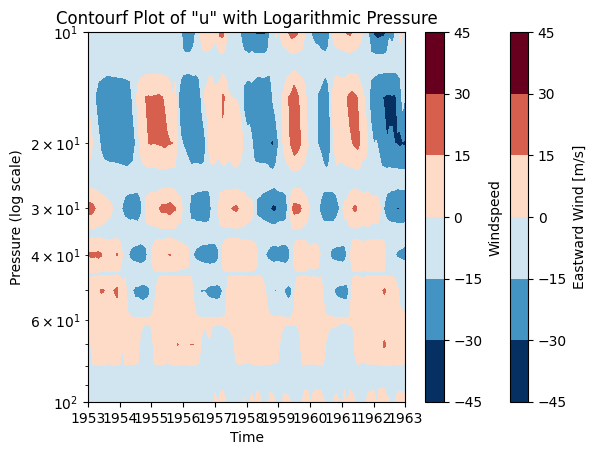

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import xarray as xr

def replace_nan(da):
    # Function to replace NaN values with the mean along the time axis
    return da.fillna(da.mean(dim='time'))

ds = xr.open_dataset('radiosonde_tropical_eastward_wind_195301.nc')

# Assuming you have 'ds' as your dataset and 'pressure' and 'u' as variables
ax = replace_nan(ds.u).plot.contourf(y='pressure', yscale='log', yincrease=False)

# Convert datetime strings to datetime objects
start_date = pd.to_datetime('1953-01-01')
end_date = pd.to_datetime('1963-01-01')

# Convert datetime objects to numeric values
start_date_num = mdates.date2num(start_date)
end_date_num = mdates.date2num(end_date)

# Get the current Axes object from the plot
# This is necessary because plot.contourf() does not return an Axes object directly
axes = plt.gca()

# Set x-axis limits
axes.set_xlim(start_date_num, end_date_num)

plt.xlabel('Time')
plt.ylabel('Pressure (log scale)')
plt.title('Contourf Plot of "u" with Logarithmic Pressure')
plt.colorbar(ax,label='Windspeed')
plt.show()

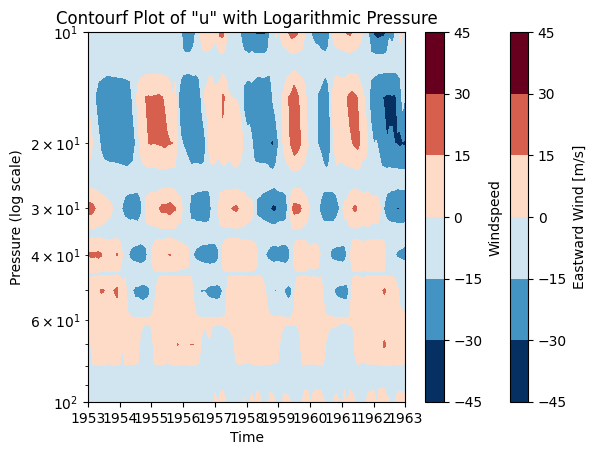

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import xarray as xr

def replace_nan(da):
    # Function to replace NaN values with the mean along the time axis
    return da.fillna(da.mean(dim='time'))

ds = xr.open_dataset('radiosonde_tropical_eastward_wind_195301.nc')

# Assuming you have 'ds' as your dataset and 'pressure' and 'u' as variables
data = replace_nan(ds.u)
if data.notnull().any():
    ax = plt.gca()
    contourf = data.plot.contourf(y='pressure', yscale='log', yincrease=False, ax=ax)

    # Convert datetime strings to datetime objects
    start_date = pd.to_datetime('1953-01-01')
    end_date = pd.to_datetime('1963-01-01')

    # Convert datetime objects to numeric values
    start_date_num = mdates.date2num(start_date)
    end_date_num = mdates.date2num(end_date)

    # Set x-axis limits
    ax.set_xlim(start_date_num, end_date_num)

    plt.xlabel('Time')
    plt.ylabel('Pressure (log scale)')
    plt.title('Contourf Plot of "u" with Logarithmic Pressure')
    plt.colorbar(contourf, label='Windspeed')
    plt.show()
else:
    print("No valid data to plot.")
